# Human Emotion Detection using Deep Learning

So our objective for today is try out basic model infrastructures and to determine what model should we finally use for our end product. We will choose the best accuracy model.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras import layers, models, optimizers, losses, metrics, callbacks
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator

## Importing Data

In [5]:
pic_size = 48

# input path for the images
base_path = "/Users/tanmaysharma/Downloads/images/"

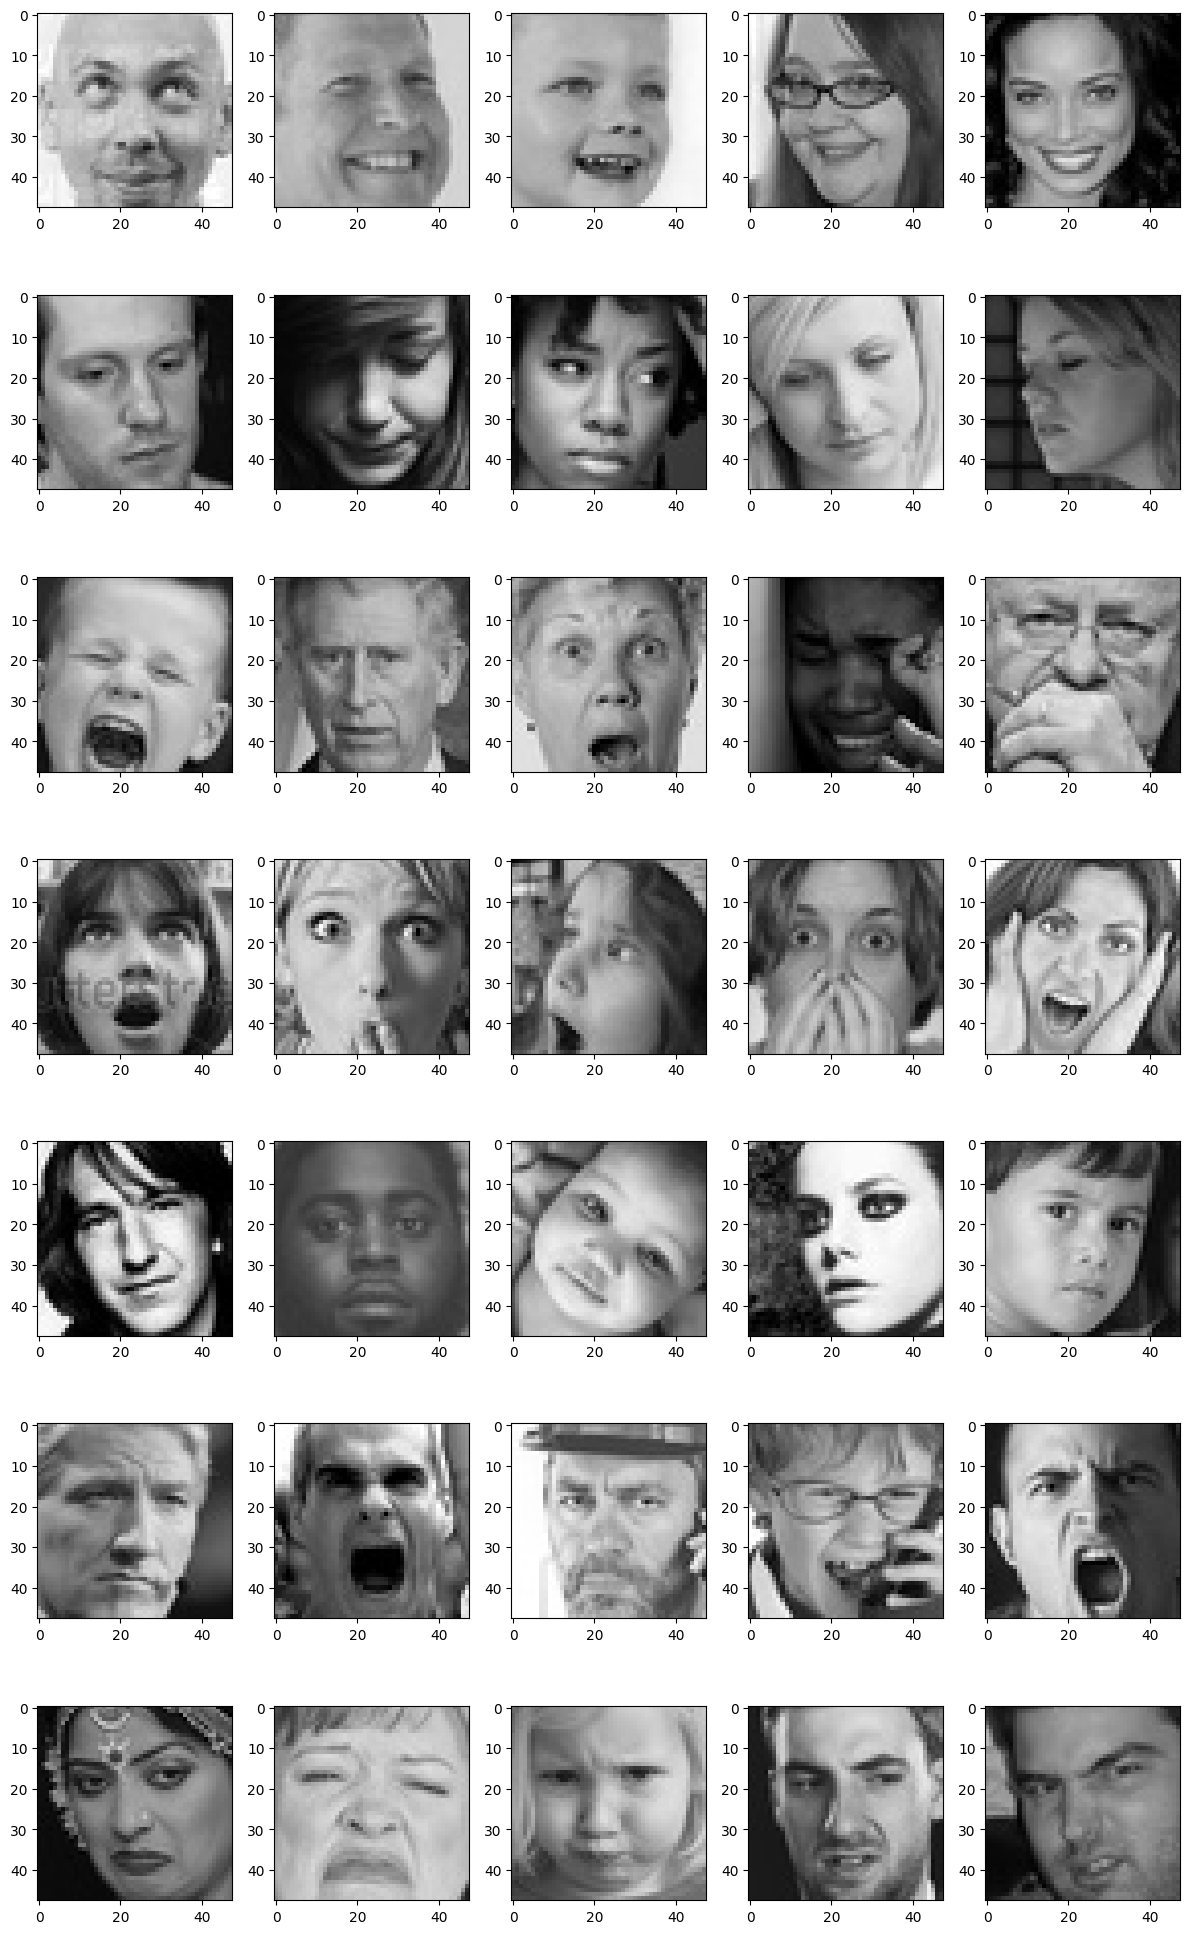

In [6]:
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

## Image Augmentation using Image Data Generator

In [7]:
batch_size = 128

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 20,
    horizontal_flip = True
)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(56,56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(56,56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


## Base Model

In [8]:
def convLoop(filters, kernel_size, strides, padding, pool_size, dropout):

    model = models.Sequential()

    model.add(layers.Conv2D(filters, kernel_size, strides, padding))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size))
    model.add(layers.Dropout(dropout))

    return model

In [9]:
def create_base_model():
    
    model = models.Sequential()

    model.add(layers.Input(shape = (56, 56, 1)))

    model.add(convLoop(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(2, 2), dropout=0.25))
    model.add(convLoop(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(2, 2), dropout=0.25))
    model.add(convLoop(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(2, 2), dropout=0.25))
    model.add(convLoop(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(2, 2), dropout=0.25))

    model.add(layers.Flatten())

    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(7, activation='softmax'))

    return model

In [19]:
def create_experiment(name, model):

    print('------------------------------------------------------------')
    print('------------------------------------------------------------')
    print('------------------------------------------------------------')
    print(f'--------------------{name} experiment----------------------')
    print('------------------------------------------------------------')
    print('------------------------------------------------------------')

    model.compile(
        optimizer = optimizers.legacy.Adam(learning_rate = 1e-3),
        loss = losses.CategoricalCrossentropy(),
        metrics = metrics.CategoricalAccuracy()
    )

    model.summary()

    reducelr = callbacks.ReduceLROnPlateau(patience = 5, factor = 0.15)
    early_stopping = callbacks.EarlyStopping(patience = 10)

    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=train_generator.n//train_generator.batch_size,
        epochs=150,
        validation_data = validation_generator,
        validation_steps = validation_generator.n//validation_generator.batch_size,
        callbacks= (reducelr, early_stopping)
    )

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation categorical accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Training Categorical Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Categorical Accuracy')
    plt.title('Training and Validation Categorical Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
        
    return history

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
--------------------Baseline experiment----------------------
------------------------------------------------------------
------------------------------------------------------------
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 28, 28, 64)        896       
                                                                 
 sequential_22 (Sequential)  (None, 14, 14, 128)       74368     
                                                                 
 sequential_23 (Sequential)  (None, 7, 7, 256)         296192    
                                                                 
 sequential_24 (Sequential)  (None, 3, 3, 512)         1182208   
                

/var/folders/f1/19ck_yvd7p355g2p8r2jyzlc0000gn/T/ipykernel_16716/1235298395.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


225/225 [==============================] - 35s 126ms/step - loss: 1.8296 - categorical_accuracy: 0.2838 - val_loss: 2.0214 - val_categorical_accuracy: 0.1801 - lr: 0.0010
Epoch 2/150
225/225 [==============================] - 24s 108ms/step - loss: 1.5359 - categorical_accuracy: 0.4043 - val_loss: 1.5984 - val_categorical_accuracy: 0.3575 - lr: 0.0010
Epoch 3/150
225/225 [==============================] - 24s 108ms/step - loss: 1.3913 - categorical_accuracy: 0.4669 - val_loss: 1.3418 - val_categorical_accuracy: 0.4814 - lr: 0.0010
Epoch 4/150
225/225 [==============================] - 24s 108ms/step - loss: 1.3138 - categorical_accuracy: 0.4982 - val_loss: 1.2107 - val_categorical_accuracy: 0.5402 - lr: 0.0010
Epoch 5/150
225/225 [==============================] - 24s 108ms/step - loss: 1.2591 - categorical_accuracy: 0.5217 - val_loss: 1.2633 - val_categorical_accuracy: 0.5259 - lr: 0.0010
Epoch 6/150
225/225 [==============================] - 24s 108ms/step - loss: 1.2217 - categorica

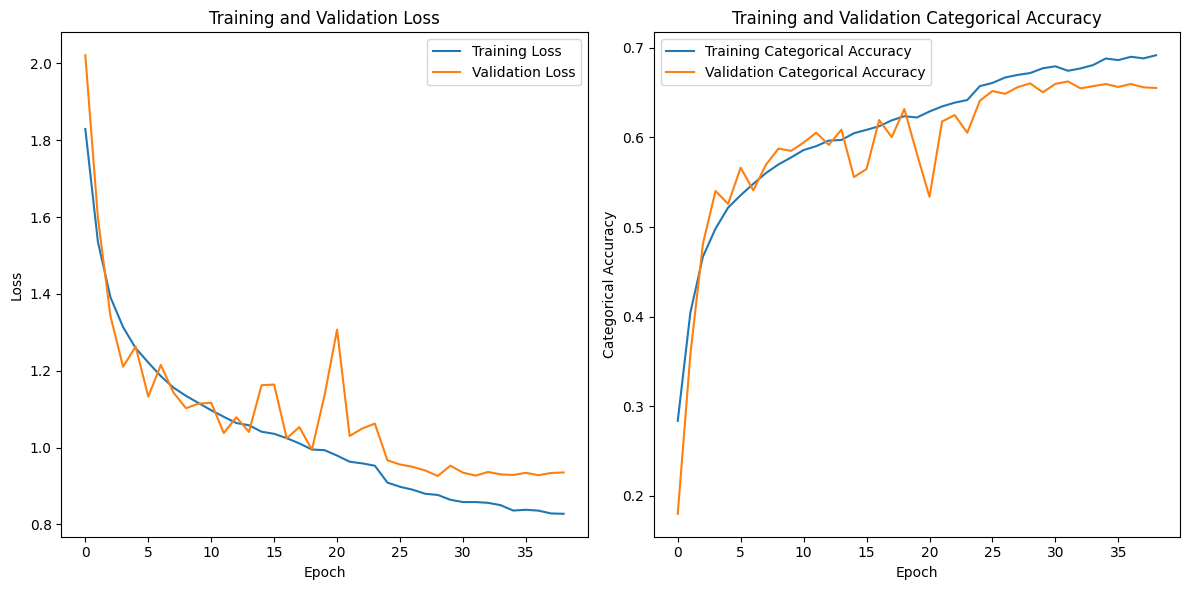

In [20]:
baseline_model = create_base_model()
history_baseline = create_experiment('Baseline', baseline_model)

## Model with a different approach for setting convolutions and poolings

In [21]:
def alternative_conv_layers(filters, kernel_size, strides, padding, pool_size, dropout, num_blocks):

    model = models.Sequential()

    for i in filters:
        for _ in range(num_blocks):
            model.add(layers.Conv2D(i, kernel_size, strides, padding))
            model.add(layers.Activation('relu'))
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size))
        model.add(layers.Dropout(dropout))
    
    return model
    

In [22]:
def create_alt_conv_model(filters = [64, 128, 256, 512]):
    
    model = models.Sequential()

    model.add(layers.Input(shape = (56, 56, 1)))

    model.add(alternative_conv_layers(filters=filters, kernel_size=(3, 3), strides=(1, 1), padding='same', pool_size=(2, 2), dropout=0.25, num_blocks = 2))
    
    model.add(layers.Flatten())

    model.add(layers.Dense(512))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.25))

    model.add(layers.Dense(7, activation='softmax'))

    return model

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
--------------------Alternative Conv experiment----------------------
------------------------------------------------------------
------------------------------------------------------------
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 3, 3, 512)         4691904   
                                                                 
 flatten_5 (Flatten)         (None, 4608)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               2359808   
                                                                 
 batch_normalization_33 (Ba  (None, 512)               2048      
 tchNorm

/var/folders/f1/19ck_yvd7p355g2p8r2jyzlc0000gn/T/ipykernel_16716/1235298395.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


225/225 [==============================] - 56s 212ms/step - loss: 1.8246 - categorical_accuracy: 0.2882 - val_loss: 1.7959 - val_categorical_accuracy: 0.2614 - lr: 0.0010
Epoch 2/150
225/225 [==============================] - 43s 190ms/step - loss: 1.4755 - categorical_accuracy: 0.4308 - val_loss: 1.6500 - val_categorical_accuracy: 0.4107 - lr: 0.0010
Epoch 3/150
225/225 [==============================] - 43s 191ms/step - loss: 1.3066 - categorical_accuracy: 0.4995 - val_loss: 1.3578 - val_categorical_accuracy: 0.4938 - lr: 0.0010
Epoch 4/150
225/225 [==============================] - 43s 192ms/step - loss: 1.2196 - categorical_accuracy: 0.5371 - val_loss: 1.2847 - val_categorical_accuracy: 0.5234 - lr: 0.0010
Epoch 5/150
225/225 [==============================] - 43s 191ms/step - loss: 1.1561 - categorical_accuracy: 0.5625 - val_loss: 1.3087 - val_categorical_accuracy: 0.4955 - lr: 0.0010
Epoch 6/150
225/225 [==============================] - 43s 191ms/step - loss: 1.1082 - categorica

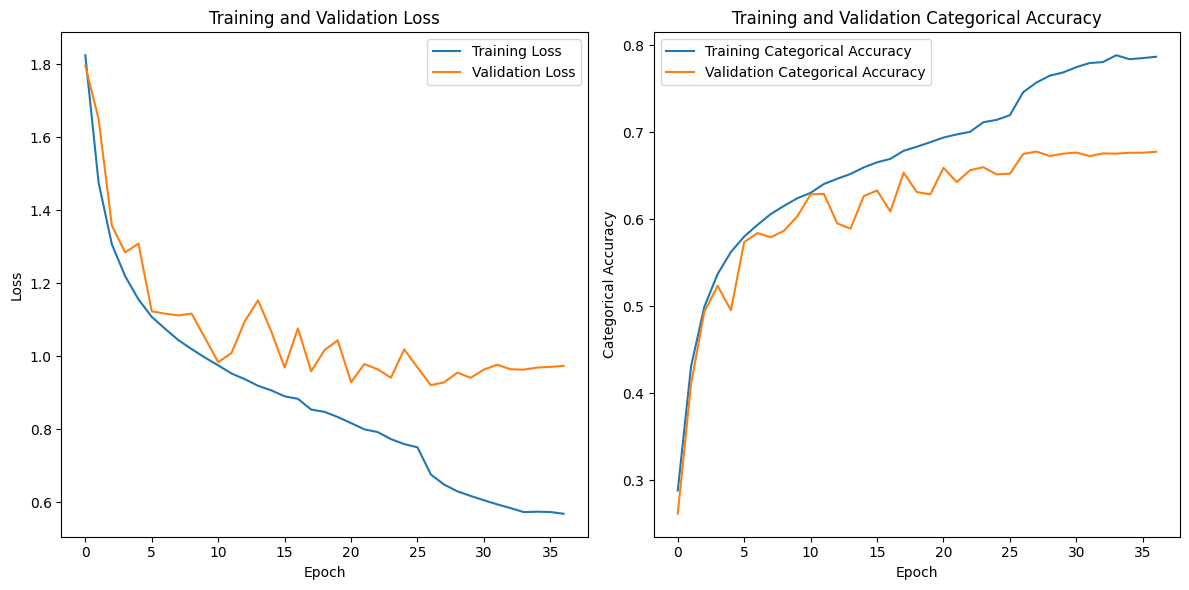

In [23]:
alt_conv_model = create_alt_conv_model()
history_alt_conv_model = create_experiment('Alternative Conv', alt_conv_model)

## Copying a Mini Version of the GoogleLeNet/InceptionV3 Architecture 

In [24]:
def inception_module(x, filters):
    
    conv1x1_1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = layers.Conv2D(filters[1], (3, 3), padding='same', activation='relu')(x)
    conv5x5 = layers.Conv2D(filters[2], (5, 5), padding='same', activation='relu')(x)
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_2 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(max_pool)

    inception_block = layers.concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_2], axis=-1)

    return inception_block


In [29]:
def inception_blocks():

    input_layer = layers.Input(shape=(56, 56, 1))  # Adjust input shape as needed

    # First block
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Second block
    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Inception modules
    x = inception_module(x, [64, 128, 32, 32])
    x = inception_module(x, [128, 192, 96, 64])
    
    # Add more inception modules as needed
    
    # Global Average Pooling
    x = layers.AveragePooling2D((7, 7))(x)
    
    # Flatten and Dense layers for classification
    x = layers.Flatten()(x)
    x = layers.Dense(units=1000, activation='relu')(x) 
    output_layer = layers.Dense(units = 7, activation = 'softmax')(x)

    return models.Model(input_layer, output_layer)

In [31]:
inception_base_model = inception_blocks()

------------------------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
--------------------Inception Base Experiment experiment----------------------
------------------------------------------------------------
------------------------------------------------------------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 56, 56, 1)]          0         []                            
                                                                                                  
 conv2d_53 (Conv2D)          (None, 28, 28, 64)           3200      ['input_10[0][0]']            
                                                                                                  
 max_

/var/folders/f1/19ck_yvd7p355g2p8r2jyzlc0000gn/T/ipykernel_16716/1235298395.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


225/225 [==============================] - 31s 107ms/step - loss: 1.8066 - categorical_accuracy: 0.2507 - val_loss: 1.7856 - val_categorical_accuracy: 0.2605 - lr: 0.0010
Epoch 2/150
225/225 [==============================] - 19s 83ms/step - loss: 1.7877 - categorical_accuracy: 0.2551 - val_loss: 1.8377 - val_categorical_accuracy: 0.2151 - lr: 0.0010
Epoch 3/150
225/225 [==============================] - 19s 84ms/step - loss: 1.7537 - categorical_accuracy: 0.2773 - val_loss: 1.6950 - val_categorical_accuracy: 0.3139 - lr: 0.0010
Epoch 4/150
225/225 [==============================] - 19s 85ms/step - loss: 1.6911 - categorical_accuracy: 0.3140 - val_loss: 1.6207 - val_categorical_accuracy: 0.3501 - lr: 0.0010
Epoch 5/150
225/225 [==============================] - 19s 84ms/step - loss: 1.6100 - categorical_accuracy: 0.3643 - val_loss: 1.5850 - val_categorical_accuracy: 0.3884 - lr: 0.0010
Epoch 6/150
225/225 [==============================] - 19s 85ms/step - loss: 1.5534 - categorical_acc

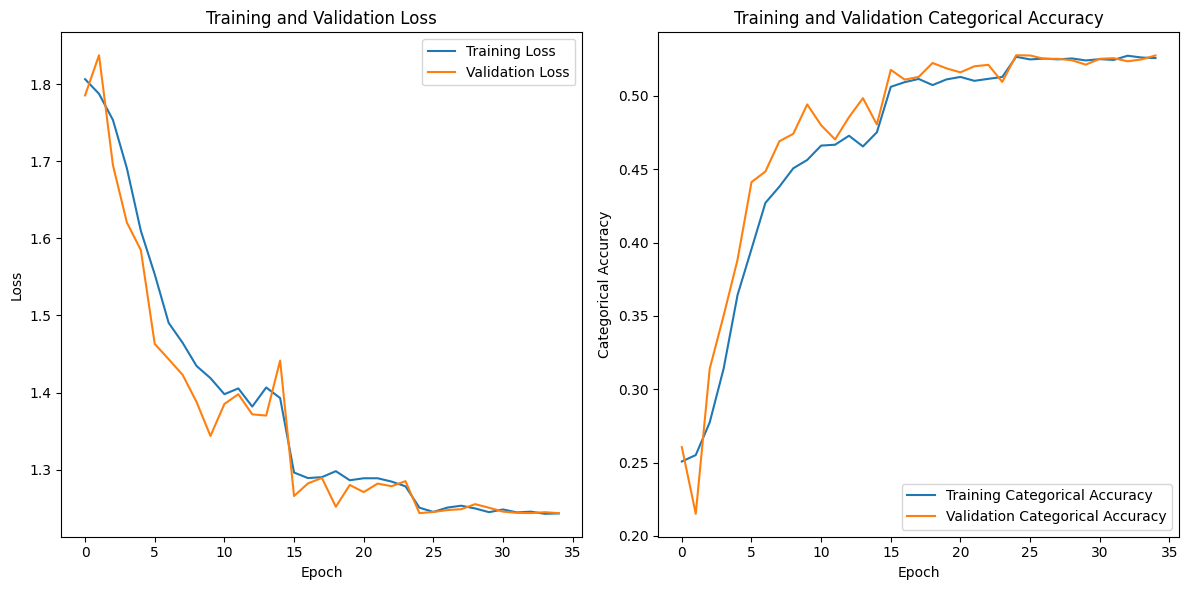

In [32]:
inception_base_model = create_experiment('Inception Base Experiment', inception_base_model)

## Conclusions

1. Base accuracy for future tuning is 70%.
2. Tranfer learning base accuracy should be around 75%.
3. Idea 2 got a little overfit, so we cannot use an even deeper network. 